In [1]:
# Libraries and packages

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataset as dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

**Dataset & Dataloaders**

In [2]:
## DATASETS
# CIFAR10

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_cifar10 = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
test_dataset_cifar10 = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)

train_data_cifar10_target, train_data_cifar10_shadow = dataset.random_split(train_dataset_cifar10, [25000, 25000])
#train_data_cifar10_target = train_dataset_cifar10
test_data_cifar10_target, test_data_cifar10_shadow = dataset.random_split(test_dataset_cifar10, [5000, 5000])
#test_data_cifar10_target = test_dataset_cifar10


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Debug Cell
print(train_dataset_cifar10.data.shape)
print(test_dataset_cifar10.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
## DATALOADERS

batch_size = 32

train_loader_cifar10_target = torch.utils.data.DataLoader(train_data_cifar10_target, batch_size=batch_size, shuffle=True)
train_loader_cifar10_shadow = torch.utils.data.DataLoader(train_data_cifar10_shadow, batch_size=batch_size, shuffle=True)
test_loader_cifar10_target = torch.utils.data.DataLoader(test_data_cifar10_target, batch_size=batch_size, shuffle=False)
test_loader_cifar10_shadow = torch.utils.data.DataLoader(test_data_cifar10_shadow, batch_size=batch_size, shuffle=False)

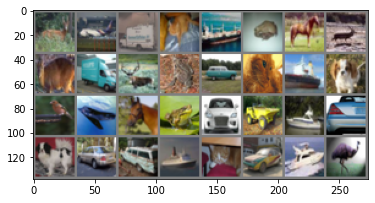

In [5]:
# Visualization Cell

def showImage(img):
    img = img / 2 + 0.5
    num_pixels = img.numpy()
    plt.imshow(np.transpose(num_pixels, (1, 2, 0)))
    plt.show()

itr = iter(train_loader_cifar10_target)
img, lbl = itr.next()
showImage(torchvision.utils.make_grid(img))

In [6]:
# Debug Cell

**Models**

In [7]:
# CIFAR10 model

class CNNCifar10(nn.Module):
    def __init__(self):
        super(CNNCifar10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 32*32 -> 28*28
        self.pool = nn.MaxPool2d(2, 2) # 28*28 -> 14*14
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 200) # 16*5*5 = 400
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x.view(-1, 400)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Training Target and getting test set for attack**

In [8]:
# Training Traget model

device = 'cuda'
model = CNNCifar10().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50
#step_count = len(train_loader_cifar10_target)

for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(train_loader_cifar10_target):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print ('Training completed...!')
torch.save(model.state_dict(), './CNNCifar10.pth')


Epoch [1/50], Loss: 2.3132
Epoch [2/50], Loss: 2.2922
Epoch [3/50], Loss: 2.2998
Epoch [4/50], Loss: 2.3142
Epoch [5/50], Loss: 2.3059
Epoch [6/50], Loss: 2.2806
Epoch [7/50], Loss: 2.3034
Epoch [8/50], Loss: 2.2994
Epoch [9/50], Loss: 2.3020
Epoch [10/50], Loss: 2.3133
Epoch [11/50], Loss: 2.2715
Epoch [12/50], Loss: 2.3174
Epoch [13/50], Loss: 2.2800
Epoch [14/50], Loss: 2.2388
Epoch [15/50], Loss: 2.1880
Epoch [16/50], Loss: 2.1178
Epoch [17/50], Loss: 2.0538
Epoch [18/50], Loss: 2.1298
Epoch [19/50], Loss: 2.1555
Epoch [20/50], Loss: 2.0692
Epoch [21/50], Loss: 1.9956
Epoch [22/50], Loss: 1.7721
Epoch [23/50], Loss: 2.1324
Epoch [24/50], Loss: 1.7206
Epoch [25/50], Loss: 2.7125
Epoch [26/50], Loss: 2.1423
Epoch [27/50], Loss: 1.6861
Epoch [28/50], Loss: 1.9888
Epoch [29/50], Loss: 1.6748
Epoch [30/50], Loss: 1.4866
Epoch [31/50], Loss: 1.5239
Epoch [32/50], Loss: 1.5252
Epoch [33/50], Loss: 1.9516
Epoch [34/50], Loss: 1.7584
Epoch [35/50], Loss: 1.6361
Epoch [36/50], Loss: 1.0809
E

In [9]:
# Producing Test data for Attack model

train_data_attack = []
train_label_attack = []
test_data_attack = []
test_label_attack = []

with torch.no_grad():
    for images, labels in train_loader_cifar10_target:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        for output in outputs.cpu().detach().numpy():
            test_data_attack.append(output)
            test_label_attack.append(1)
    
    for images, labels in test_loader_cifar10_target:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        for output in outputs.cpu().detach().numpy():
            test_data_attack.append(output)
            test_label_attack.append(0)

test_data = np.array(test_data_attack)
test_label = np.array(test_label_attack)

In [10]:
print (test_data.shape)
print (test_label.shape)

(30000, 10)
(30000,)


In [11]:
# Debug cell

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader_cifar10_target:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(min(batch_size, images.size(0))):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]}: {acc:.2f} %')
        
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in train_loader_cifar10_target:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(min(batch_size, images.size(0))):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the train in network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]}: {acc:.2f} %')
    
    

Accuracy of the network: 45.4 %
plane: 54.61 %
car: 54.62 %
bird: 28.85 %
cat: 26.45 %
deer: 28.85 %
dog: 34.92 %
frog: 68.79 %
horse: 54.08 %
ship: 48.52 %
truck: 54.44 %
Accuracy of the train in network: 45.664 %
plane: 51.56 %
car: 56.22 %
bird: 31.65 %
cat: 27.02 %
deer: 31.71 %
dog: 35.96 %
frog: 67.26 %
horse: 49.70 %
ship: 52.23 %
truck: 54.42 %


**Implementing shadow model**

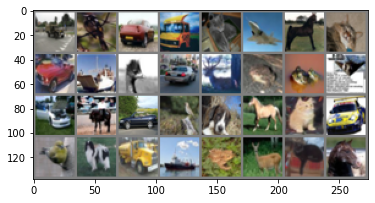

In [12]:
# Visualization Cell

def showImage(img):
    img = img / 2 + 0.5
    num_pixels = img.numpy()
    plt.imshow(np.transpose(num_pixels, (1, 2, 0)))
    plt.show()

itr = iter(test_loader_cifar10_target)
img, lbl = itr.next()
showImage(torchvision.utils.make_grid(img))

In [13]:
# Training shadow model
# We are doing attack 1 (white box attack), so the shadow model is same as target model
# but different dataset of similar distribution

device = 'cuda'
model_shadow = CNNCifar10().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50
#step_count = len(train_loader_cifar10_target)

for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(train_loader_cifar10_shadow):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_shadow(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print ('Training completed...!')
torch.save(model_shadow.state_dict(), './CNNCifar10Shadow.pth')


Epoch [1/50], Loss: 2.2646
Epoch [2/50], Loss: 2.2869
Epoch [3/50], Loss: 2.2998
Epoch [4/50], Loss: 2.2992
Epoch [5/50], Loss: 2.3029
Epoch [6/50], Loss: 2.3003
Epoch [7/50], Loss: 2.2998
Epoch [8/50], Loss: 2.3173
Epoch [9/50], Loss: 2.2784
Epoch [10/50], Loss: 2.2811
Epoch [11/50], Loss: 2.2944
Epoch [12/50], Loss: 2.3073
Epoch [13/50], Loss: 2.3100
Epoch [14/50], Loss: 2.3209
Epoch [15/50], Loss: 2.2950
Epoch [16/50], Loss: 2.3106
Epoch [17/50], Loss: 2.2845
Epoch [18/50], Loss: 2.2940
Epoch [19/50], Loss: 2.3099
Epoch [20/50], Loss: 2.2654
Epoch [21/50], Loss: 2.3283
Epoch [22/50], Loss: 2.2961
Epoch [23/50], Loss: 2.3236
Epoch [24/50], Loss: 2.3026
Epoch [25/50], Loss: 2.3220
Epoch [26/50], Loss: 2.3078
Epoch [27/50], Loss: 2.3344
Epoch [28/50], Loss: 2.2769
Epoch [29/50], Loss: 2.2949
Epoch [30/50], Loss: 2.3116
Epoch [31/50], Loss: 2.2693
Epoch [32/50], Loss: 2.3389
Epoch [33/50], Loss: 2.2828
Epoch [34/50], Loss: 2.2776
Epoch [35/50], Loss: 2.2806
Epoch [36/50], Loss: 2.3295
E

In [14]:
# Producing Train data for Attack model

train_data_attack = []
train_label_attack = []

with torch.no_grad():
    for images, labels in train_loader_cifar10_shadow:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_shadow(images)
        for output in outputs.cpu().detach().numpy():
            train_data_attack.append(output)
            train_label_attack.append(1)
    
    for images, labels in test_loader_cifar10_shadow:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        for output in outputs.cpu().detach().numpy():
            train_data_attack.append(output)
            train_label_attack.append(0)

train_data = np.array(train_data_attack)
train_label = np.array(train_label_attack)

In [15]:
print (train_data.shape)
print (train_label.shape)

(30000, 10)
(30000,)


In [16]:
# Debug cell

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader_cifar10_shadow:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_shadow(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(min(batch_size, images.size(0))):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]}: {acc:.2f} %')
        
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in train_loader_cifar10_shadow:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_shadow(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(min(batch_size, images.size(0))):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the train in network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]}: {acc:.2f} %')
    
    

Accuracy of the network: 9.44 %
plane: 0.00 %
car: 0.00 %
bird: 0.00 %
cat: 0.00 %
deer: 6.88 %
dog: 0.00 %
frog: 89.60 %
horse: 1.50 %
ship: 0.00 %
truck: 0.00 %
Accuracy of the train in network: 9.928 %
plane: 0.00 %
car: 0.00 %
bird: 0.00 %
cat: 0.00 %
deer: 4.48 %
dog: 0.00 %
frog: 90.06 %
horse: 3.22 %
ship: 0.00 %
truck: 0.00 %


**Implementing attack model**

In [17]:
# feature scalling

from sklearn.preprocessing import StandardScaler

train_data = StandardScaler().fit_transform(train_data)
test_data = StandardScaler().fit_transform(test_data)

In [18]:
# dataset class
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

In [19]:
# creating datasets
trainset = dataset(train_data, train_label)
testset = dataset(test_data, test_label)

# dataloader for attack
train_loader = DataLoader (trainset, batch_size=50, shuffle=True)
test_loader = DataLoader (testset, batch_size=50, shuffle=True)

In [20]:
# Binary classifier attack model

class BCNet (nn.Module):
    def __init__(self, input_shape):
        super(BCNet, self).__init__()
        self.fc1 = nn.Linear(input_shape, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [21]:
print (train_data.shape[1])
print (train_label.shape)

10
(30000,)


In [22]:
# Training attack model

model_attack = BCNet(input_shape=train_data.shape[1]).to(device)
learning_rate = 0.01
num_epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    for idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        labels = labels.reshape(-1,1)
        
        outputs = model_attack(data)
        #print (labels.shape)
        #print (outputs.shape)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print ('Training completed...!')
torch.save(model_attack.state_dict(), './CNNCifar10Attack.pth')


Epoch [1/50], Loss: 0.6662
Epoch [2/50], Loss: 0.6663
Epoch [3/50], Loss: 0.6653
Epoch [4/50], Loss: 0.6683
Epoch [5/50], Loss: 0.6699
Epoch [6/50], Loss: 0.6664
Epoch [7/50], Loss: 0.6602
Epoch [8/50], Loss: 0.6584
Epoch [9/50], Loss: 0.6667
Epoch [10/50], Loss: 0.6651
Epoch [11/50], Loss: 0.6729
Epoch [12/50], Loss: 0.6607
Epoch [13/50], Loss: 0.6693
Epoch [14/50], Loss: 0.6622
Epoch [15/50], Loss: 0.6654
Epoch [16/50], Loss: 0.6647
Epoch [17/50], Loss: 0.6683
Epoch [18/50], Loss: 0.6607
Epoch [19/50], Loss: 0.6651
Epoch [20/50], Loss: 0.6657
Epoch [21/50], Loss: 0.6697
Epoch [22/50], Loss: 0.6595
Epoch [23/50], Loss: 0.6644
Epoch [24/50], Loss: 0.6763
Epoch [25/50], Loss: 0.6699
Epoch [26/50], Loss: 0.6654
Epoch [27/50], Loss: 0.6635
Epoch [28/50], Loss: 0.6682
Epoch [29/50], Loss: 0.6663
Epoch [30/50], Loss: 0.6671
Epoch [31/50], Loss: 0.6640
Epoch [32/50], Loss: 0.6630
Epoch [33/50], Loss: 0.6630
Epoch [34/50], Loss: 0.6661
Epoch [35/50], Loss: 0.6755
Epoch [36/50], Loss: 0.6619
E

In [23]:
# Getting precision and recall

tp = 0
fp = 0
fn = 0

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for data, labels in test_loader:
        #print ("in")
        data = data.to(device)
        labels = labels.to(device)
        labels = labels.reshape(-1).detach().cpu().numpy()
        #print (labels)
        outputs = model_attack(data)
        outputs = outputs.reshape(-1).detach().cpu().numpy().round()
        #print (outputs)
        
        for i in range(min(batch_size, data.size(0))):
            #print ("hi")
            label = labels[i]
            pred = outputs[i]
            if (label == pred and label != 0):
                tp += 1
            elif (label != pred and label != 0):
                fn += 1
            elif (label != pred and label == 0):
                fp += 1
            if (label == pred):
                n_correct += 1
            n_samples += 1

    acc = 100.0 * n_correct / n_samples
    
    print(f'Accuracy of the network: {acc:.4f} %')
    print(f'Precision: {(tp/(tp+fp)):.4f}')
    print(f'Recall: {(tp/(tp+fn)):.4f}')

Accuracy of the network: 73.3490 %
Precision: 0.8361
Recall: 0.8471
